In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.utils import data
from IPython import display
from matplotlib import pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [2]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, torch.reshape(y, (-1, 1))

def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [3]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size, is_train=False)

In [4]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [5]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [6]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda x: linreg(x, w, b), squared_loss
    num_epochs, lr = 100, 0.003
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                       xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for x, y in train_iter:
            with torch.enable_grad():
                l = loss(net(x), y) + lambd * l2_penalty(w)
            l.sum().backward()
            sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                    evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

In [7]:
def squared_loss(y_hat, y):
    return (y_hat - reshape(y, y_hat.shape))**2 / 2

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
def use_svg_display():
    display.set_matplotlib_formats('svg')
    
def linreg(X, w, b):
    return torch.matmul(X, w) + b

def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            
def evaluate_loss(net, data_iter, loss):
    metric = Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = reshape(y, out.shape)
        l = loss(out, y)
        metric.add(reduce_sum(l), size(l))
    return metric[0] / metric[1]

class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
            
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

w的L2范数是： 13.542023658752441


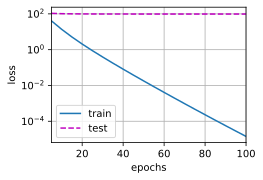

In [8]:
train(lambd=0)

w的L2范数是： 0.38506177067756653


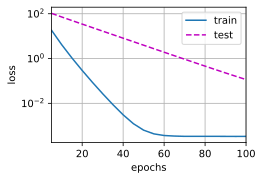

In [9]:
train(lambd=3)

In [10]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([
        {'params': net[0].weight,
        'weight_decay': wd}, 
        {'params': net[0].bias}], lr=lr)
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                       xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for x, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(x), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                    evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.927355766296387


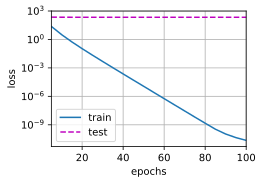

In [11]:
train_concise(0)

w的L2范数： 0.4724513292312622


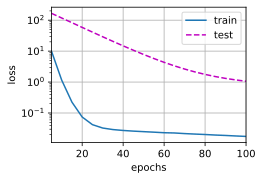

In [12]:
train_concise(3)